In [128]:
!pip install python_speech_features

In [129]:
!unzip '/content/drive/MyDrive/ML Project/LUMS_FALL2020_PROJECT_DATA.zip' -d '/content/'

Archive:  /content/drive/MyDrive/ML Project/LUMS_FALL2020_PROJECT_DATA.zip
replace /content/Gender_Recognition/Test/SPK083_M/1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [251]:
import python_speech_features as mfcc
from scipy.io.wavfile import read
import numpy as np
import pandas as pd
import re
import os
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,classification_report

*Functions below will be used in both Gender classification and Speaker classification*

In [252]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

In [253]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [254]:
# feature extraction for speaker recognition
def feature_extraction_S(dir):
  df=pd.DataFrame()
  Y=[]
  for i in sorted_alphanumeric(os.listdir(dir)):
    for files in os.listdir(dir+i):
      sr, audio = read(dir+i+'/'+files)
      features = get_MFCC(audio, sr)
      row=pd.Series(features)
      df=df.append(row,ignore_index=True)
      Y.append(int(i[3:6]))
  return df,Y

In [255]:
# feature extraction for gender recognition
def gen_features_G(dir):
  df=pd.DataFrame()
  Y=[]
  for i in sorted_alphanumeric(os.listdir(dir)):
    for files in os.listdir(dir+i):
      sr, audio = read(dir+i+'/'+files)
      features = get_MFCC(audio, sr)
      row=pd.Series(features)
      df=df.append(row,ignore_index=True)
      if i[-1]=='F':
        Y.append(0)
      elif i[-1]=='M':
        Y.append(1)
  return df,Y

In [256]:
# Sigmoid function
def sigmoid(z):
  s = 1/(1+np.exp(-z))
  return s

In [257]:
# Function for forward propagation
def propagate(train_X,train_Y,w,j):
  
  m=train_Y.size
  A= sigmoid(np.dot(np.transpose(w),np.transpose(train_X)))
  cost = -(1/m)*(np.sum(train_Y.iloc[:,j]*np.log(A)+(1-train_Y.iloc[:,j])*np.log(1-A)))
  dz=A-train_Y.iloc[:,j]
  
  dw=(1/m)*(np.dot(np.transpose(train_X),np.transpose(dz)))
  return dw,cost

In [258]:
# function to update weights and calculate costs
def optimize(train_X,train_Y,w,epochs,alpha,cost_arr,Y_train):
  for i in range(epochs):
    for j in range(len(np.unique(Y_train))):
      w=pd.DataFrame(w)
      dw,cost=propagate(train_X,train_Y,w.iloc[:,j],j)
      cost_arr[i][j]=cost
      w.iloc[:,j]=w.iloc[:,j]-(alpha*dw)
  return w,cost_arr

In [259]:
# function which calculates the Y_pred according to given threshold
def predict(w,test_X,Y_pred):
  m=test_X.shape[0]
  A=sigmoid(np.dot(np.transpose(w),np.transpose(test_X)))
  A=np.transpose(A)
  return A
  # return pred

In [267]:
def predictions(theta,features_test,Y_train,df_test):
  output = []
  pred=[]
  for i in range(len(np.unique(Y_train))):
    Y_pred=np.zeros((df_test.shape[0],1))
    theta = pd.DataFrame(theta)
    if i>0:
      Y_pred=h
    h = predict(theta.iloc[:,i], features_test,Y_pred)
    output.append(h)
  dff=pd.DataFrame(output)
  for i in range(features_test.shape[0]):
    y=np.argmax(dff[i])+1
    pred.append(y)
  return pred

#**Speaker Recognition**

In [261]:
# Directories of all datasets
dir_train='/content/Speaker_Recognition/Train/'
dir_valid='/content/Speaker_Recognition/Valid/'
dir_test='/content/Speaker_Recognition/Test/'

In [262]:
# Extracting features and Y values of all the datasets 

df_train,Y_train=feature_extraction_S(dir_train)
df_valid,Y_valid=feature_extraction_S(dir_valid)
df_test,Y_test=feature_extraction_S(dir_test)

In [263]:
# Inserting row of 1 in all feature vectors for bias term.
features_vec=np.insert(df_train.values,0,1,axis=1)
features_valid=np.insert(df_valid.values,0,1,axis=1)
features_test=np.insert(df_test.values,0,1,axis=1)

In [264]:
# Creating list of size number of instances in train  x number of classes (142)
# This might take few seconds
# One hot encoding
Y_train=np.array(Y_train)
# Initializing all the values to zero
y1=np.zeros([df_train.shape[0],len(np.unique(Y_train))])
y1=pd.DataFrame(y1)
for i in range(0, len(np.unique(Y_train))):
    for j in range(0, len(y1)):
        if Y_train[j] == np.unique(Y_train)[i]:
            y1.iloc[j, i] = 1
        else: 
            y1.iloc[j, i] = 0

In [265]:
# This cell is used for training
# optimize function returns theta array and array containing cost of each class in each iteration  
# This might take 10-15 minutes
theta=np.zeros([df_train.shape[1]+1,y1.shape[1]])
cost_arr=np.zeros([1500,len(np.unique(Y_train))])
theta,cost_arr=optimize(features_vec,y1,theta,1500,0.5,cost_arr,Y_train)

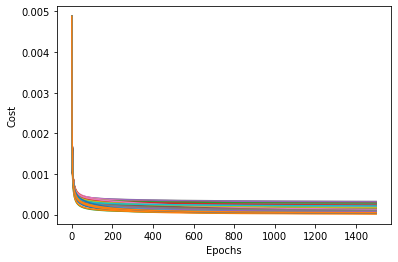

In [268]:
# Plots the graph of cost vs number of iterations for all classes i.e. 142 lines
cost_arr=pd.DataFrame(cost_arr)
for i in range(cost_arr.shape[1]):
  plt.plot(cost_arr[i])
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

In [269]:
pred=predictions(theta,features_test,Y_train,df_test)

In [270]:
accuracy=accuracy_score(Y_test,pred)
print('Accuracy:',accuracy)

Accuracy: 0.9014084507042254


In [271]:
f1score=f1_score(Y_test,pred,average='macro')
print(f1score)

0.8927230046948357


In [272]:
matrix=confusion_matrix(Y_test,pred)
print('Confusion Matrix:')
print(matrix)

Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [273]:
classification_rep=classification_report(Y_test,pred,zero_division=1)
print(classification_rep)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         2
          10       0.67      1.00      0.80         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      0.50      0.67         2
          17       0.67      1.00      0.80         2
          18       1.00    

## **Gender Recognition**

In [274]:
# Directories of all datasets
dir_train_G='/content/Gender_Recognition/Train/'
dir_valid_G='/content/Gender_Recognition/Valid/'
dir_test_G='/content/Gender_Recognition/Test/'

In [275]:
# Extracting features and Y values of all the datasets 
df_train_G,Y_train_G=gen_features_G(dir_train_G)
df_valid_G,Y_valid_G=gen_features_G(dir_valid_G)
df_test_G,Y_test_G=gen_features_G(dir_test_G)

In [276]:
# Inserting row of 1 in all feature vectors for bias term.
df_train_G=np.insert(df_train_G.values,0,1,axis=1)
features_valid_G=np.insert(df_valid_G.values,0,1,axis=1)
features_test_G=np.insert(df_test_G.values,0,1,axis=1)

In [277]:
# Creating list of size number of instances in train  x number of classes (2)
# one-hot encoding
Y_train_G=np.array(Y_train_G)
# Initializing all the values to 0
y2=np.zeros([df_train_G.shape[0],len(np.unique(Y_train_G))])
y2=pd.DataFrame(y2)
for i in range(0, len(np.unique(Y_train_G))):
    for j in range(0, len(y2)):
        if Y_train_G[j] == np.unique(Y_train_G)[i]:
            y2.iloc[j, i] = 1
        else: 
            y2.iloc[j, i] = 0

In [278]:
# This cell is used for training
# optimize function returns theta array and array containing cost of each class in each iteration
theta2=np.zeros([df_train_G.shape[1],y2.shape[1]])
cost_arr2=np.zeros([1500,len(np.unique(Y_train_G))])
theta2,cost_arr2=optimize(df_train_G,y2,theta2,1500,0.01,cost_arr2,Y_train_G)

In [279]:
# All the values of Y_pred are calculated and stored in an array
output = []
pred=[]
for i in range(len(np.unique(Y_train_G))):
  Y_pred=np.zeros((df_valid_G.shape[0],1))
  theta2 = pd.DataFrame(theta2)
  if i>0:
    Y_pred=h
  h = predict(theta2.iloc[:,i],features_test_G ,Y_pred)
  output.append(h)
dff=pd.DataFrame(output)
for i in range(features_test_G.shape[0]):
  # Taking argmax across all classes
  y=np.argmax(dff[i])
  pred.append(y)


In [280]:
accuracy=accuracy_score(Y_test_G,pred)
print('Accuracy:',accuracy)

Accuracy: 0.8352941176470589


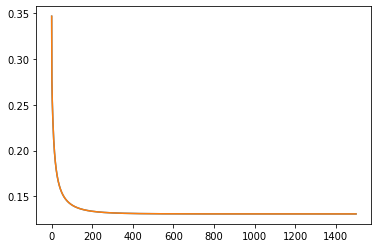

In [281]:
# Plots the graph of cost vs number of iterations for all classes i.e. 2
cost_arr2=pd.DataFrame(cost_arr2)
plt.figure()
for i in range(cost_arr2.shape[1]):
  plt.plot(cost_arr2[i])
plt.show()


In [282]:
report=classification_report(Y_test_G,pred)
print('Classification Report\n\n')
print(report)

Classification Report


              precision    recall  f1-score   support

           0       0.69      0.55      0.61        40
           1       0.87      0.92      0.90       130

    accuracy                           0.84       170
   macro avg       0.78      0.74      0.75       170
weighted avg       0.83      0.84      0.83       170

